In [2]:
from transformers import (CLIPProcessor, CLIPModel, CLIPTextModel, AutoTokenizer, AutoProcessor, CLIPVisionModel)
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from PIL import Image
from zipfile import ZipFile
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/kartik/git/685-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Name of the pre-trained base model
base_model_name = 'openai/clip-vit-base-patch32'

# Pre-trained CLIP model
model = CLIPModel.from_pretrained(base_model_name)
processor = CLIPProcessor.from_pretrained(base_model_name)

In [119]:
x = torch.Tensor([[1,2,3],[3,2,1]])
x

tensor([[1., 2., 3.],
        [3., 2., 1.]])

In [124]:
x.max(axis=0).values.softmax(dim=0)

tensor([0.4223, 0.1554, 0.4223])

In [136]:
class CLIPWrapper:
    ADJECTIVES = ['bigger', 'cleaner', 'hairier', 'older', 'colder', 'longer',
       'harder', 'drier', 'closer', 'fatter', 'curlier', 'riper',
       'blacker', 'heavier', 'sharper', 'fuller', 'shinier', 'smoother',
       'rustier', 'coarser', 'fresher', 'flatter', 'narrower', 'thicker',
       'higher', 'lighter', 'brighter', 'curvier', 'deeper', 'farther',
       'newer', 'bluer', 'shorter', 'denser', 'flakier', 'fewer',
       'fancier', 'cloudier', 'broader']
    
    A_to_I = {adj: i for i, adj in enumerate(ADJECTIVES)}

    def __init__(self, clip_model, clip_processor, template_pos:str, template_neg:str):
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.template_pos = template_pos
        self.template_neg = template_neg

    def set_template(self, template_pos:str, template_neg:str):
        self.template_pos = template_pos
        self.template_neg = template_neg

    def get_pos_preds(self, dataset):
        n = len(dataset)
        imgs = [data['image'] for data in dataset]
        labels = [CLIPWrapper.A_to_I[data['adjective']] for data in dataset]
        texts_1 = [self.template_pos.format(adjective=adj) for adj in self.ADJECTIVES]
        texts_2 = [self.template_pos.format(adjective=adj_antonym_reverse.get(adj, adj)) for adj in self.ADJECTIVES]
        inputs = self.clip_processor(text=texts_1+texts_2, images=imgs, return_tensors='pt', padding=True)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            logits_per_image = logits_per_image.reshape((n, 2, -1)).mean(axis=1).values     # can be mean?
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            # return probs, labels
            return {'preds':probs, 'labels':labels}
        
    def get_neg_preds(self, dataset):
        n = len(dataset)
        imgs = [data['image'] for data in dataset]
        labels = [CLIPWrapper.A_to_I[data['adjective']] for data in dataset]
        # texts = [self.template_neg.format(adj=adj) for adj in self.ADJECTIVES]
        texts_1 = [self.template_neg.format(adjective=adj) for adj in self.ADJECTIVES]
        texts_2 = [self.template_neg.format(adjective=adj_antonym_reverse.get(adj, adj)) for adj in self.ADJECTIVES]
        inputs = self.clip_processor(text=texts_1+texts_2, images=imgs, return_tensors='pt', padding=True)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            logits_per_image = outputs.logits_per_image            # not negating the output of negative prompts
            logits_per_image = logits_per_image.reshape((n, 2, -1)).mean(axis=1).values   # doing min to give best chance
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            # return probs, labels
            return {'preds':probs, 'labels':labels}
        
    def get_contrastive_preds(self, dataset):
        n = len(dataset)
        imgs = [data['image'] for data in dataset]
        labels = [CLIPWrapper.A_to_I[data['adjective']] for data in dataset]
        texts = []
        for adj in self.ADJECTIVES:
            texts.append(self.template_pos.format(adj=adj))
            texts.append(self.template_neg.format(adj=adj))
        inputs = self.clip_processor(text=texts, images=imgs, return_tensors='pt', padding=True)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            logits_per_image = logits_per_image.reshape((n, -1, 2))
            logits_per_image_contrastive = logits_per_image[...,0] - logits_per_image[...,1]        # pos - neg
            probs_per_image_contrastive = logits_per_image_contrastive.softmax(axis=-1).cpu().numpy()
            # return probs_per_image_contrastive, labels
            return {'preds':probs_per_image_contrastive, 'labels':labels}
        

In [137]:
dataset = load_dataset('Final_Dataset', split='train')
print(dataset.shape)

template_pos = 'The objects in this image can be compared using the adjective \'{adjective}\'.'
template_neg = 'The objects in this image cannot be compared using the adjective \'{adjective}\'.'
wrapper = CLIPWrapper(model, processor, template_pos, template_neg)

Found cached dataset final_dataset (/Users/kartik/.cache/huggingface/datasets/final_dataset/default/0.0.0/ff78fd73bcc051f1cecb0ccb2ac8e7e02fc7cb3d082e8aca8c11cbeee057a425)


(257, 2)


In [144]:
dataset.info

DatasetInfo(description='Demo dataset for demo purposes.\n', citation='Bibtex citation\n', homepage='homepage for the dataset (e.g. github repo)', license='(MIT?)', features={'image': Image(decode=True, id=None), 'adjective': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='final_dataset', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=78094303, num_examples=257, shard_lengths=None, dataset_name='final_dataset'), 'test': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='final_dataset')}, download_checksums={'data.zip': {'num_bytes': 76562529, 'checksum': None}, 'metadata/train.csv': {'num_bytes': 3209, 'checksum': None}, 'metadata/test.csv': {'num_bytes': 21, 'checksum': None}}, download_size=76565759, post_processing_size=None, dataset_size=78094303, size_in_bytes=154660062)

In [138]:
preds_pos = wrapper.get_pos_preds(dataset)
print(preds_pos['preds'].shape)

preds_neg = wrapper.get_neg_preds(dataset)
print(preds_neg['preds'].shape)

# preds_contrastive = wrapper.get_contrastive_preds(dataset)
# print(preds_contrastive['preds'].shape)

(257, 39)
(257, 39)


In [ ]:
def get_top_k_accs(k_vals, print_results=True, **preds):
    k_accs = {key:[] for key in preds}
    k_accs['random'] = []
    l = len(CLIPWrapper.ADJECTIVES)

    for k in k_vals:
        print_strs = [f'Top - {k:2} accuracy:: ']
        for key, value in preds.items():
            acc = top_k_accuracy_score(value['labels'], value['preds'], k=k)
            k_accs[key].append(acc)
            print_strs.append(f'{key}: {acc*100:6.2f}%. ')
        k_accs['random'].append(k/l)
        print_strs.append(f'Random: {(k/l)*100:6.2f}%.')

        if print_results:
            print(*print_strs)

    return k_accs

def plot_top_k_accs(k_vals, k_accs):
    fig, ax = plt.subplots()
    for key, value in k_accs.items():
        if key=='random':
            ax.plot(k_vals, value, label='Random guessing', linewidth=0.5, linestyle='--')
        else:
            ax.plot(k_vals, value, label=key, marker='o')
    ax.set_xlabel('k')
    ax.set_ylabel('Top-k accuracy')
    ax.set_title('Top-k accuracy vs k')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 39)
    ax.legend()
    fig.show()

In [88]:
metadata_df = pd.read_csv('Final_Dataset/metadata/train.csv')

In [97]:
metadata_df.to_csv('Final_Dataset/metadata/train.csv', index=False)

In [98]:
metadata_df['adjective'].unique()

array(['bigger', 'cleaner', 'hairier', 'older', 'colder', 'longer',
       'harder', 'drier', 'closer', 'fatter', 'curlier', 'riper',
       'blacker', 'heavier', 'sharper', 'fuller', 'shinier', 'smoother',
       'rustier', 'coarser', 'fresher', 'flatter', 'narrower', 'thicker',
       'higher', 'lighter', 'brighter', 'curvier', 'deeper', 'farther',
       'newer', 'bluer', 'shorter', 'denser', 'flakier', 'fewer',
       'fancier', 'cloudier', 'broader'], dtype=object)

In [91]:
metadata_df['adjective'].nunique()

64

In [92]:
metadata_df['adjective']=metadata_df['adjective'].apply(lambda x: adj_antonym_mapping.get(x, x))

In [93]:
metadata_df['adjective'].nunique()

39

In [82]:
adj_antonym_mapping = {
    'smaller': 'bigger',
    'dimmer': 'brighter',
    'slimmer': 'broader',
    'dirtier': 'cleaner',
    'farther': 'closer',
    'sunnier': 'cloudier',
    'finer': 'coarser',
    'hotter': 'colder',
    'warmer': 'cooler',
    'straighter': 'curlier',
    'shallower': 'deeper',
    'wetter': 'drier',
    'later': 'earlier',
    'plainer': 'fancier',
    'nearer': 'farther',
    'skinnier': 'fatter',
    'rounder': 'flatter',
    'staler': 'fresher',
    'emptier': 'fuller',
    'softer': 'harder',
    'lighter': 'heavier',
    'lower': 'higher',
    'darker': 'lighter',
    'shorter': 'longer',
    'wider': 'narrower',
    'younger': 'older',
    'blunter': 'sharper',
    'duller': 'shinier',
    'taller': 'shorter',
    'rougher': 'smoother',
    'thinner': 'thicker'}

In [99]:
adj_antonym_reverse = dict()
for k, v in adj_antonym_mapping.items():
    adj_antonym_reverse[v] = k

In [102]:
len(adj_antonym_mapping)

31

In [86]:
found_set = set()
for k, v in adj_antonym_mapping.items():
    found_set.add(k)
    found_set.add(v)
for a in CLIPWrapper.ADJECTIVES:
    if a not in found_set:
        print(a)

hairier
riper
blacker
rustier
curvier
newer
bluer
denser
flakier
fewer


Top -  1 accuracy::  positive:  15.56%.  negative:  12.06%.  Random:   2.56%.
Top -  2 accuracy::  positive:  24.51%.  negative:  15.56%.  Random:   5.13%.
Top -  5 accuracy::  positive:  40.86%.  negative:  27.24%.  Random:  12.82%.
Top - 10 accuracy::  positive:  50.97%.  negative:  47.08%.  Random:  25.64%.
Top - 20 accuracy::  positive:  77.04%.  negative:  69.65%.  Random:  51.28%.
Top - 32 accuracy::  positive:  93.39%.  negative:  91.83%.  Random:  82.05%.


/var/folders/91/2vsvzkhd2m1cs8fkz6v51dkw0000gn/T/ipykernel_12881/2899755726.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


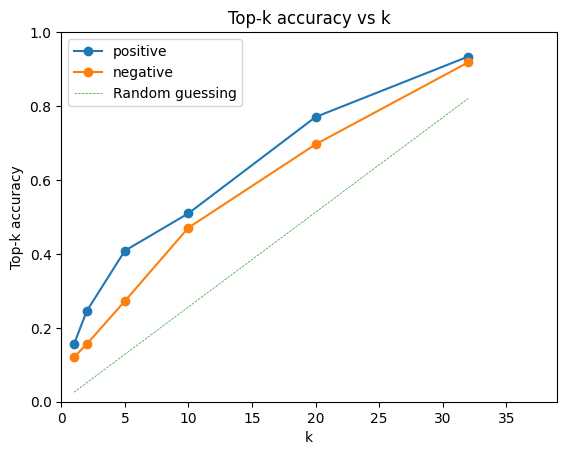

In [139]:
k_vals = [1, 2, 5, 10, 20, 32]
k_accs = get_top_k_accs(k_vals, positive=preds_pos, negative=preds_neg)#, contrastive=preds_contrastive)
plot_top_k_accs(k_vals, k_accs)

/var/folders/91/2vsvzkhd2m1cs8fkz6v51dkw0000gn/T/ipykernel_75560/3621981112.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


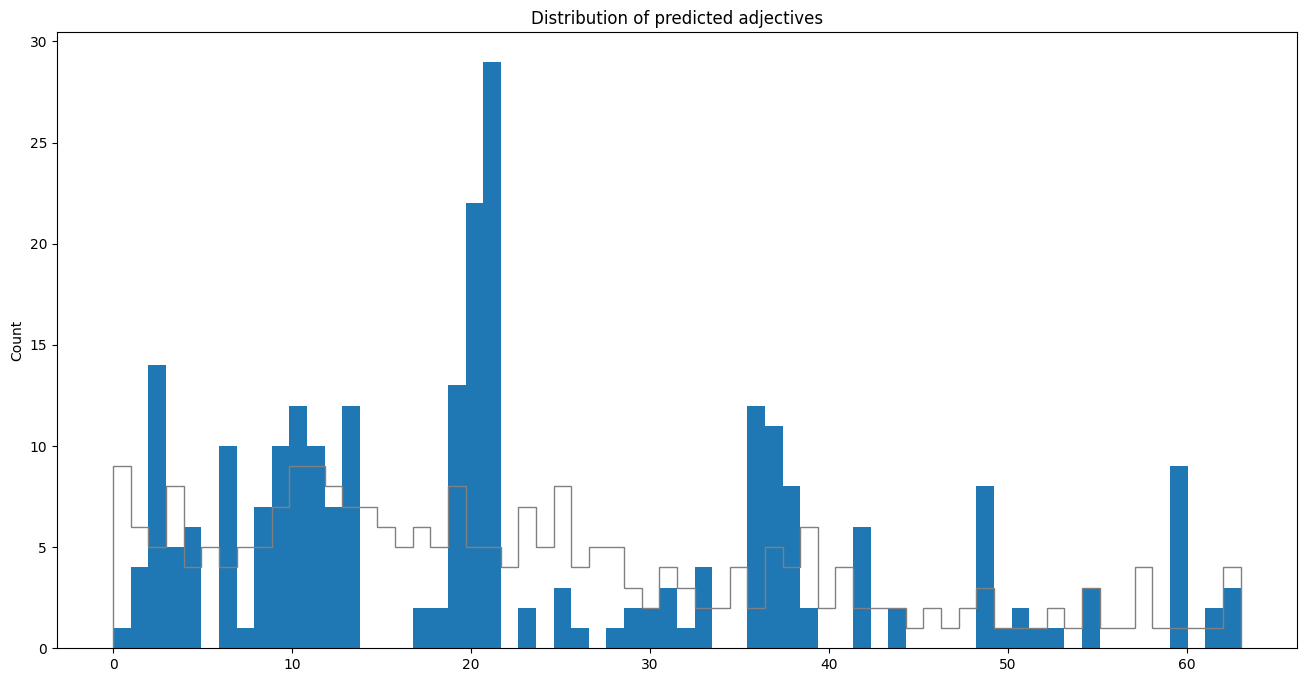

In [57]:
preds_int = preds.argmax(axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(labels, bins=len(CLIPWrapper.ADJECTIVES), histtype='step', color='gray')
ax.hist(preds_int, bins=len(CLIPWrapper.ADJECTIVES))

# make histogram of labels in line style
# ax.set_xticks(range(len(CLIPWrapper.ADJECTIVES)))
# ax.set_xticklabels(CLIPWrapper.ADJECTIVES, rotation=90)
# ax.set_xlabel('Adjective')
ax.set_ylabel('Count')
ax.set_title('Distribution of predicted adjectives')
fig.show()

In [60]:
l = [1, 11, 2, 22, 3, 33, 4, 44, 5, 55]
nl = np.array(l)
nl.reshape(5, 2)

array([[ 1, 11],
       [ 2, 22],
       [ 3, 33],
       [ 4, 44],
       [ 5, 55]])

In [109]:
nl = np.array([[1,1,1,11,11,11], [2,2,2,22,22,22]])
n = len(nl)
nl.reshape((n, 2,-1)).max(axis=1)

array([[11, 11, 11],
       [22, 22, 22]])

In [104]:
nl.reshape((n,-1,2))

array([[[ 1,  1],
        [ 1, 11],
        [11, 11]],

       [[ 2,  2],
        [ 2, 22],
        [22, 22]]])